In [1]:
import tensorflow as tf
import numpy as np
import cv2 as cv
from tensorflow.io import gfile
from PIL import Image
import tempfile
import os
from six.moves import urllib
import tarfile

class DeepLabModel(object):
    """Class to load deeplab model and run inference."""

    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        graph_def = None

        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.compat.v1.Session(graph=self.graph)

    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):
        """Runs inference on a single image.

        Args:
            image: A PIL.Image object, raw input image.
            INPUT_TENSOR_NAME: The name of input tensor, default to ImageTensor.
            OUTPUT_TENSOR_NAME: The name of output tensor, default to SemanticPredictions.

        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        target_size = (2049,1025)  # size of Cityscapes images
        resized_image = image.convert('RGB').resize(target_size, Image.Resampling.LANCZOS)
        batch_seg_map = self.sess.run(
            OUTPUT_TENSOR_NAME,
            feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]  # expected batch size = 1
        if len(seg_map.shape) == 2:
            seg_map = np.expand_dims(seg_map,-1)  # need an extra dimension for cv.resize
        seg_map = cv.resize(seg_map, (width,height), interpolation=cv.INTER_NEAREST)
        return seg_map

MODEL_NAME = 'mobilenetv2_coco_cityscapes_trainfine'
#MODEL_NAME = 'xception65_cityscapes_trainfine'

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_trainfine':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.io.gfile.makedirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...

model loaded successfully!


In [ ]:
def compute_M(seg_map, source_img_path, target_img_path, sift, bf):
    '''
    seg_map: segmentation map of the source image, a numpy array of shape (height, width)
    source_img_path: path to the source image
    target_img_path: path to the target image
    sift: cv2.SIFT object
    bf: cv2.BFMatcher object
    '''

    unique_labels = np.unique(seg_map)

    source_img = cv.imread(source_img_path)
    target_img = cv.imread(target_img_path)

    gray_source = cv.cvtColor(source_img, cv.COLOR_BGR2GRAY)
    gray_target = cv.cvtColor(target_img, cv.COLOR_BGR2GRAY)

    # Function to extract and match features for each label
    def compute_transform(label, seg_map, gray_frame_0, gray_frame_16):
        mask = seg_map == label
        keypoints_0, descriptors_0 = sift.detectAndCompute(gray_frame_0, mask.astype(np.uint8))
        keypoints_16, descriptors_16 = sift.detectAndCompute(gray_frame_16, mask.astype(np.uint8))
        try:
            matches = bf.knnMatch(descriptors_16, descriptors_0, 4)
            #matches = sorted(matches, key=lambda x: x.distance)
            try:
                #top_matches = matches[:int(len(matches) * 0.1)]

                if len(matches) >= 4:  # Minimum number of matches to estimate a transform
                    pts_0 = np.float32([keypoints_0[m[0].queryIdx].pt for m in matches]).reshape(-1, 1, 2)
                    pts_16 = np.float32([keypoints_16[m[1].trainIdx].pt for m in matches]).reshape(-1, 1, 2)
                    # estimate projective transform
                    M, mask = cv.estimateAffinePartial2D(pts_0, pts_16)
                #elif len(matches) >= 4:
                #    print(f"Warning: Not enough matches for label {label}. Using all {len(matches)} matches.")
                #    pts_0 = np.float32([keypoints_0[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
                #    pts_16 = np.float32([keypoints_16[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
                #    M, mask = cv.estimateAffinePartial2D(pts_0, pts_16)
                else:
                    print(f"Not engough matches for label {label}. Using identical transform.")
                    M = np.eye(2,3)
            except:
                M = np.array([[1,0,0],[0,1,0]]).astype(np.float64)
        except:
            matches = bf.knnMatch(descriptors_0, descriptors_16, 4)
            #matches = sorted(matches, key=lambda x: x.distance)
            try:
                #top_matches = matches[:int(len(matches) * 0.1)]

                if len(matches) >= 4:  # Minimum number of matches to estimate a transform
                    pts_0 = np.float32([keypoints_0[m[0].queryIdx].pt for m in matches]).reshape(-1, 1, 2)
                    pts_16 = np.float32([keypoints_16[m[1].trainIdx].pt for m in matches]).reshape(-1, 1, 2)
                    # estimate projective transform
                    M, mask = cv.estimateAffinePartial2D(pts_0, pts_16)
                #elif len(matches) >= 4:
                #    print(f"Warning: Not enough matches for label {label}. Using all {len(matches)} matches.")
                #    pts_0 = np.float32([keypoints_0[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
                #    pts_16 = np.float32([keypoints_16[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
                #    M, mask = cv.estimateAffinePartial2D(pts_0, pts_16)
                else:
                    print(f"Not engough matches for label {label}. Using identical transform.")
                    M = np.eye(2,3)
            except:
                M = np.array([[1,0,0],[0,1,0]]).astype(np.float64)

        return M
    
    # Compute transforms for each label
    transforms = {label: compute_transform(label, seg_map, gray_source, gray_target) for label in unique_labels}

    return transforms

In [5]:
def global_motion_estimation(bf_path, af_path, target_path, bf_gray_path, af_gray_path, target_gray_path, model):
    '''
    bf_path, af_path: RGB image for segmentation, a string
    bf_gray_path, af_gray_path, target_gray_path: gray image for feature extraction, a string
    model: DeepLabModel object
    '''

    # read teh gray images
    bf_gray = cv.imread(bf_gray_path)
    af_gray = cv.imread(af_gray_path)
    target_gray = cv.imread(target_gray_path)

    bf_gray = cv.cvtColor(bf_gray, cv.COLOR_BGR2GRAY)
    af_gray = cv.cvtColor(af_gray, cv.COLOR_BGR2GRAY)
    target_gray = cv.cvtColor(target_gray, cv.COLOR_BGR2GRAY)

    # read the RGB images
    #bf_image = Image.open(bf_path)
    #af_image = Image.open(af_path)

    # segment the images
    #bf_seg_map = model.run(bf_image)
    #af_seg_map = model.run(af_image)

    seg_map = model.run(Image.open(target_path))
    """
    for y in range(16, target_gray.shape[0], 16):
        for x in range(16, target_gray.shape[1], 16):
            seperate = seg_map[y-16:y, x-16:x]
            seperate = seperate.reshape(256)
            #print(seperate.shape)
            counts = np.bincount(seperate)
            #print(counts)
            seg_map[y-16: y, x-16: x] = np.argmax(counts)
    """
    return seg_map
    # compute each M matrix for bf and af images' labels
    sift = cv.SIFT_create()
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)

    bf_M_dic = compute_M(seg_map, bf_gray_path, target_gray_path, sift, bf)
    af_M_dic = compute_M(seg_map, af_gray_path, target_gray_path, sift, bf)

    # tansform
    bf_predict = np.zeros_like(target_gray)
    af_predict = np.zeros_like(target_gray)

    for label, M in bf_M_dic.items():
        mask = seg_map == label
        #transformed_frame = cv.warpPerspective(bf_gray, M, (bf_gray.shape[1], bf_gray.shape[0]))
        transformed_frame = cv.warpAffine(bf_gray, M, (bf_gray.shape[1], bf_gray.shape[0]))
        bf_predict[mask] = transformed_frame[mask]

    
    for label, M in af_M_dic.items():
        mask = seg_map == label
        transformed_frame = cv.warpAffine(af_gray, M, (af_gray.shape[1], af_gray.shape[0]))
        af_predict[mask] = transformed_frame[mask]
    
    """ 
    for label, M in bf_M_dic.items():
        mask = seg_map == label
        transformed_frame = cv.warpAffine(bf_gray, M, (bf_gray.shape[1], bf_gray.shape[0]))
        bf_predict[mask] = transformed_frame[mask]
    
    
    for label, M in af_M_dic.items():
        if(M != np.eye(2,3)):
            mask = seg_map == label
            transformed_frame = cv.warpAffine(af_gray, M, (af_gray.shape[1], af_gray.shape[0]))
            af_predict[mask] = transformed_frame[mask]
    """

    # weighted sum
    alpha = 0.5
    target_predict = cv.addWeighted(bf_predict, alpha, af_predict, 1 - alpha, 0)

    return target_predict

start to process image16



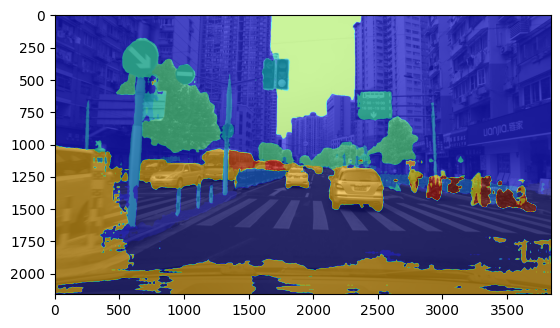

start to process image8



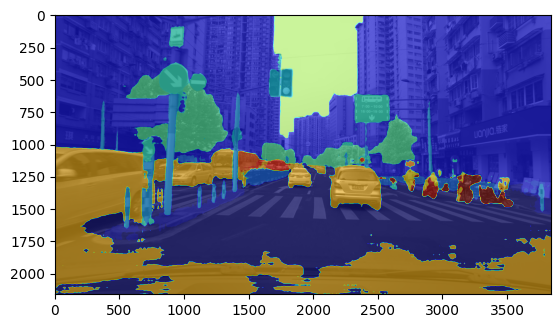

start to process image4



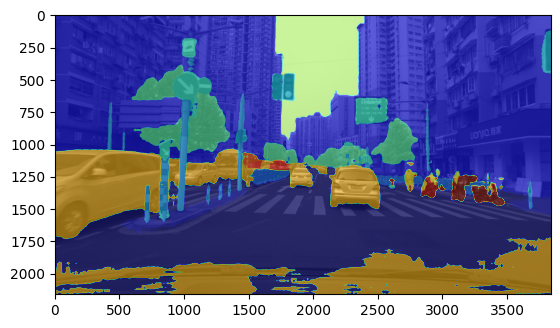

start to process image2



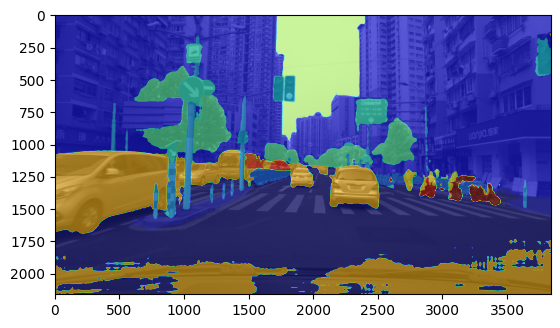

start to process image1



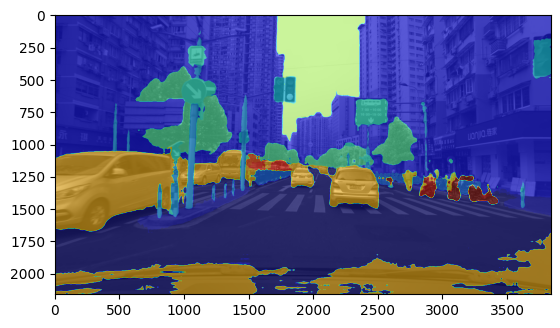

start to process image3



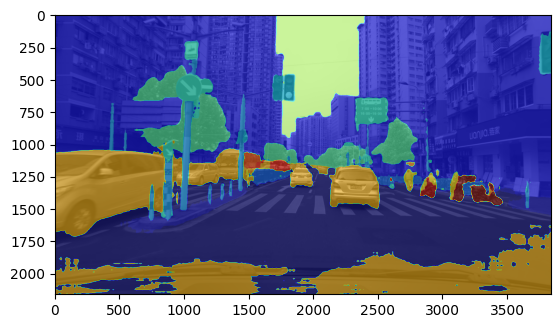

start to process image6



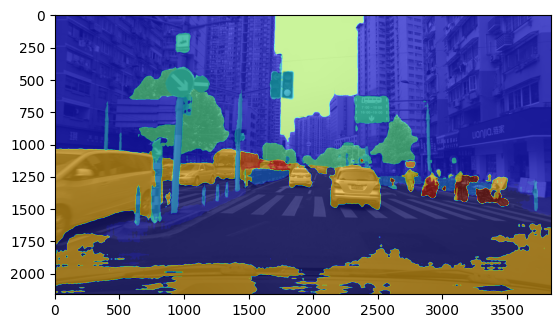

start to process image5



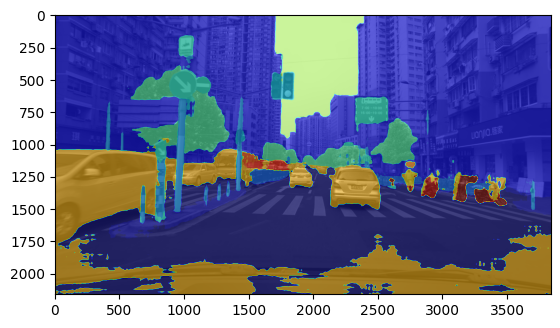

start to process image7



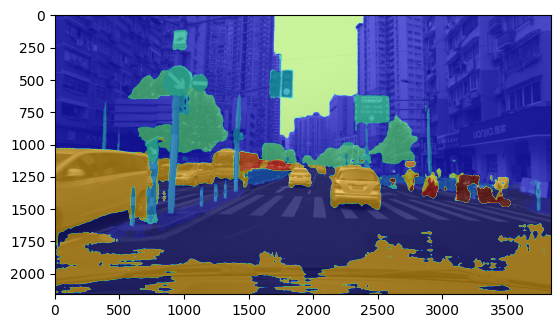

start to process image12



KeyboardInterrupt: 

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
ref = pd.read_csv('reference.csv')
for i in range(len(ref['target'])):
    print(f"start to process image{ref['target'][i]}\n")
    bf_path = './rgb_images/%03d.png' % ref['ref0'][i]
    af_path = './rgb_images/%03d.png' % ref['ref1'][i]
    target_path = './rgb_images/%03d.png' % ref['target'][i]

    bf_gray_path = './gt/%03d.png' % ref['ref0'][i]
    af_gray_path = './gt/%03d.png' % ref['ref1'][i]
    target_gray_path = './gt/%03d.png' % ref['target'][i]

    predict_frame = global_motion_estimation(bf_path, af_path, target_path, bf_gray_path, af_gray_path, target_gray_path, MODEL)
    
    plt.imshow(cv.imread(target_gray_path), cmap='gray', vmin=0, vmax=255)
    plt.imshow(predict_frame, cmap='jet', alpha=0.5)
    plt.show()
    #cv.imwrite('./solution/%03d.png' % ref['target'][i], predict_frame)